In [1]:
import random as rnd
from math import *
import matplotlib.pyplot as plt
from matplotlib import cm
# plt.xkcd()

In [2]:
def foo(p):
    if rnd.uniform(0,1) < p:
        return 1
    return 0

In [16]:
foo(0.9)

1

In [4]:
class DRange(object):
    """
    Класс описывает непрерывный интервал вещественных чисел [a;b], используемый как ген в хромосоме,
    а так же инструменты для кроссовера, мутации, интерполяции значений в интервале
    """
    diap = 0.4
    diap_cross = 0.1
    def __init__(self, a, b, name='drange'):
        """
        a    левая (или правая) граница интервала гена
        b    правая(или левая)  граница интервала гена
        name имя гена
        """
        self.a = min(a, b)
        self.b = max(a, b)
        self.name = name

        
    def get_rnd_value(self):
        """
        функция генерации случайного значения в интервале
        """
        return rnd.uniform(self.a, self.b)
        
        
    def __repr__(self):
        return f"DRange({self.a}, {self.b}, name='{self.name}')"


    def validate_value(self, value):
        if value > self.b:
            return self.b
        elif value < self.a:
            return self.a
        return value


    def cross(self, x1, x2):
        """
        Кроссовер двух генов (с использованием нормального распределения)
        
        x1     значение гена первого родителя
        x2     значение гена второго родителя
        
        return значение гена потомка
        """
        x1, x2  =min(x1,x2), max(x1,x2)
        left = x1 - (x2-x1)*self.diap_cross
        right = x2 + (x2-x1)*self.diap_cross
        return self.validate_value( rnd.uniform(left, right) )

    def mutate(self, mu):
        """
        Мутация гена (с использованием нормального распределения)
        
        mu     значение гена до мутации
        
        return значение гена после мутации
        """
        x1 = mu - (self.b - self.a)*self.diap*0.5
        x2 = mu + (self.b - self.a)*self.diap*0.5
        x1 = self.validate_value(x1)
        x2 = self.validate_value(x2)
        return rnd.uniform(x1, x2)

In [5]:
d = DRange(-10,10, 'sdd')
d

DRange(-10, 10, name='sdd')

In [6]:
class ChromoController(object):
    """
    Класс описывает хромосому постоянной структуры
    а так же инструменты для кроссовера, мутации, интерполяции хромосом
    """

    def __init__(self, ranges):
        """
        ranges      список описаний генов (гены должны иметь разные имена!!!)
        constraints список функций для определения пригодности хромосомы, функции вида
                    f(chr) -> float, где chr - хромосома (создается функциями get_chromo, cross, mutate, interp, 
                    find_zero_golden_method). Если возврацаемое значение >= 0, то хромосома приемлимая
        """
        self.ranges_dict = {r.name: r for r in ranges}
        self.ranges_list = [r for r in ranges]

    def __repr__(self):
        return f"ChromoController({repr(self.ranges_list)},constraints = {repr(self.constraints)})"

    def __getitem__(self, key):
        if key in self.ranges_dict:
            return self.ranges_dict[key]
        return self.ranges_list[key]

    def get_chromo(self):
        """
        метод получения новой хромосомы со случайными значениями генов
        """
        ch = {}
        for k in self.ranges_dict:
            ch[k] = self[k].get_rnd_value()
#         ch = {key: self[key].get_rnd_value() for key in self.ranges_dict}
        return ch

    def cross(self, chromo1, chromo2):
        """
        метод проведения кроссовера двух хромосом
        
        chromo1, chromo2  хромосомы родителей
        
        return            хромосома-потомок
        """
        child = {}
        for k in self.ranges_dict:
            child[k] = self[k].cross(chromo1[k], chromo2[k])
#         child = {key: self[key].cross(chromo1[key], chromo2[key]) for key in self}
        return child

    def mutate(self, chromo, keys):
        """
        метод проведения мутации хромосомы 
        
        chromo  хромосома-родитель
        keys    имена мутирующих генов
        
        return  хромосома-мутант
        """
        mutant = dict(chromo)
        mutant.pop('fitness', None)
        for key in keys:
            mutant[key] = self[key].mutate(mutant[key])
        return mutant

In [7]:
class Population(object):
    def __init__(self, chr_contr, fitn_foo, pop=None, age=0):
        self.chr_contr =  chr_contr
        self.fitn_foo = fitn_foo
        self.pop = pop
        self.age = age
        
    def init_new_pop(self, n):
        self.pop = [self.chr_contr.get_chromo() for _ in range(n)]
        self.age = 0
    
    def fitness_me(self):
        for chromo in self.pop:
            if 'fitness' in chromo:
                continue
            chromo['fitness'] = self.fitn_foo(chromo)
    
    def select_parents(self, n_parents):
        def get_winner():
            c1, c2 = rnd.choices(self.pop, k=2)
            return c1 if c1['fitness'] > c2['fitness'] else c2
        return [get_winner() for _ in range(n_parents)]
    
    def get_children(self, n_children):
        parents = self.select_parents(n_children*2)
        return [self.chr_contr.cross(p1, p2) for p1, p2 in zip(parents[:n_children], parents[n_children:])]
    
    def get_mutants(self, p_mut, p_mut_gene):
        mutants = []
        for c in self.pop:
            if rnd.random() < p_mut:
                keys = [k for k in c if k != 'fitness' and rnd.random() < p_mut_gene]
                if len(keys) == 0:
                    continue
                mutant = self.chr_contr.mutate(c, keys)
                mutants.append(mutant)
        return mutants
    
    def get_next_pop(self, children, mutants, n_elite=1, n=None):
        pop = sorted(self.pop, reverse=True, key=lambda c: c['fitness'])
        if n is None:
            n = len(self.pop)
        loosers = pop[n_elite:]
        loosers_weights = [1]*len(loosers)
        children_weights = [2]*len(children)
        mutant_weights = [2]*len(mutants)
        
        next_pop = rnd.choices(loosers+children+mutants,
                              weights=loosers_weights+children_weights+mutant_weights,
                              k=n-n_elite)
        next_pop += pop[:n_elite]
        return Population(self.chr_contr, self.fitn_foo, next_pop, self.age+1)
    
    def get_best_chromo(self):
        pop_with_fitness = [c for c in self.pop if 'fitness' in c]
        return max(pop_with_fitness, key=lambda c: c['fitness']) if any(pop_with_fitness) else None
    
    def __str__(self):
        best_fit = self.get_best_chromo()
        if best_fit is not None:
            best_fit = best_fit['fitness']
        return f'Popunation(age={self.age}, best_fit={best_fit})'
    
    def __repr__(self):
        return str(self)
        

In [8]:
ranges = []
ranges.append(DRange(-30, 40, 'param_1'))
ranges.append(DRange(-10, 50, 'another_param'))
ranges.append(DRange(0, 4, 'aaand_some'))

chr_contr = ChromoController(ranges)

In [9]:
def fit_fun(chromo):
    p1 = chromo['param_1']
    p2 = chromo['another_param']
    p3 = chromo['aaand_some']
    some_const = 10
    res = some_const - (p1**2 + p2**2 + p3**2)
    return res

In [10]:
n = 100
pop = Population(chr_contr, fit_fun)
pop.init_new_pop(n)
bests = []
pop

Popunation(age=0, best_fit=None)

Popunation(age=10, best_fit=9.236663749925349)

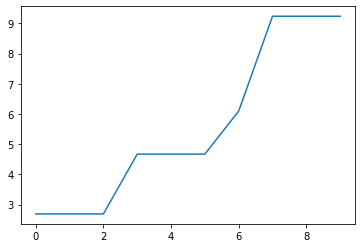

In [11]:
for _ in range(10):
    pop.fitness_me()
    bests.append(pop.get_best_chromo())
    children = pop.get_children(60)
    mutants = pop.get_mutants(0.1, 0.3)
    pop = pop.get_next_pop(children, mutants)

fitnesses = [c['fitness'] for c in bests]
plt.plot(fitnesses)
pop

In [12]:
pop.get_best_chromo()

{'param_1': 0.6779582522250607,
 'another_param': -0.22844709780643768,
 'aaand_some': 0.5015184760488973,
 'fitness': 9.236663749925349}

In [14]:
from matplotlib import cm
from matplotlib.colors import ListedColormap
import numpy as np

viridis = cm.get_cmap('Blues', 1024)
newcolors = viridis(np.linspace(0, 1, 1024))
newcolors[-16:, :] = cm.get_cmap('winter', 16)(np.linspace(0.5, 1, 16))
newcmp = ListedColormap(newcolors)

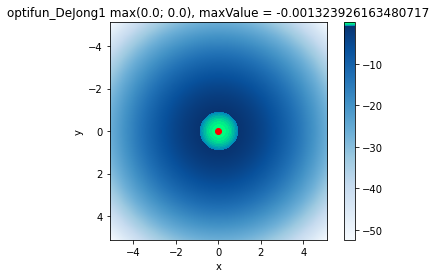

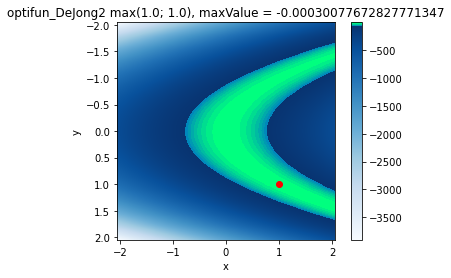

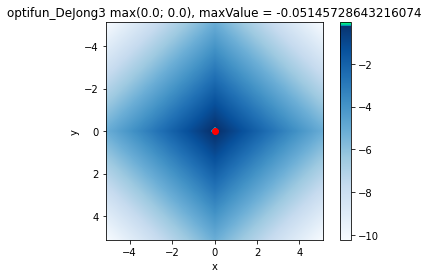

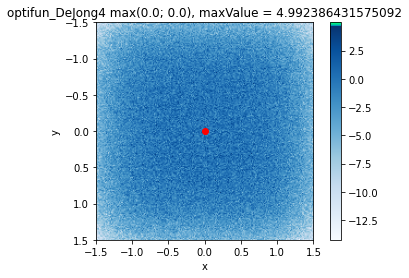

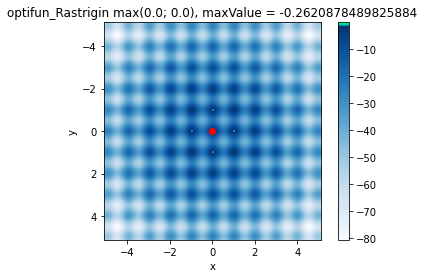

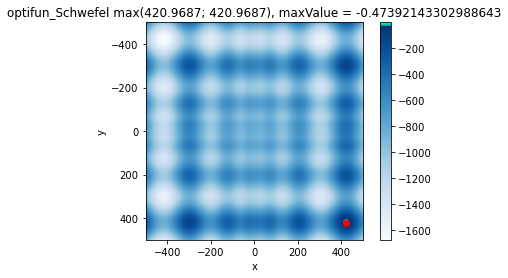

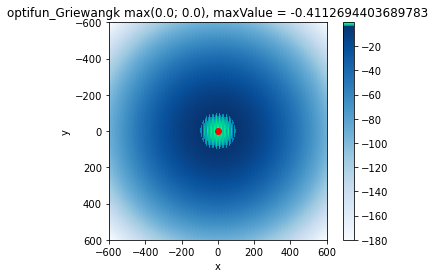

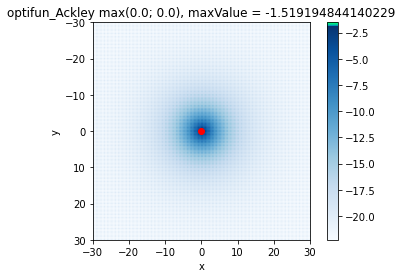

In [15]:
from TestFunctions import main
main(newcmp)